In [353]:
# Standard imports
import numpy as np
import pylab as plt
from scipy import stats
import torch

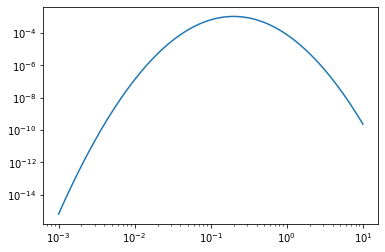

In [355]:
def alpha(r, rs = 0.2, alpha_max = 1e-3, steepness = 1):
    return alpha_max*np.exp(-np.log(r/rs)**2)**steepness

r = np.logspace(-3, 1, 100)
plt.loglog(r, alpha(r))

In [356]:
def source(x, y, freq = 10, w = 0.3):
    r = (x**2 + y**2)**0.5
    s = np.cos(x*freq)**2*np.cos(y*freq)**2+1
    s = np.exp(-0.5*r**2/w**2)*s
    return s/s.max()*100

In [357]:
def disp(X, Y, x0, y0, **kwargs):
            r = ((X-x0)**2 + (Y-y0)**2)**0.5
            cx = (X-x0)/r
            cy = (Y-y0)/r
            d = alpha(r, **kwargs)
            return -d*cx, -d*cy

In [361]:
def simulator(w = 0.03, nsub = 1, subpos = None, source_kwargs = {}):
    grid = np.linspace(-2.5, 2.5, 100, 100)
    X, Y = np.meshgrid(grid, grid)
    dX = np.zeros_like(X)
    dY = np.zeros_like(X)
    
    DX, DY = disp(X, Y, 0.8, 0.2, alpha_max = 2.5, rs = 1)
    
    # Add random distortions in terms of lines
    _subpos = []
    for i in range(nsub):
        if subpos is None:
            x0, y0 = np.random.rand(2)*5 - 2.5
        else:
            x0, y0 = subpos[i]   
        _subpos.append([x0, y0])
        a, b = disp(X, Y, x0, y0)
        dX += a
        dY += b
        
    mu = source(X + dX + DX, Y + dY + DY, **source_kwargs)
    
    return dict(dX = dX, dY = dY, mu = mu, DX = DX, DY = DY, X=X, Y=Y, subpos = _subpos)

def noise(obs, sigma=0.0):
    mu = obs['mu']
    n = np.random.randn(*mu.shape)*sigma
    obs['mu'] = mu + n
    return obs

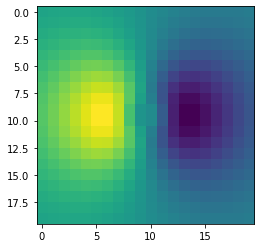

In [362]:
grid = np.linspace(-2.5, 2.5, 100, 100)
X, Y = np.meshgrid(grid, grid)
kx, ky = disp(X, Y, 0., 0.)
kx = kx[40:60,40:60]
ky = ky[40:60,40:60]
plt.imshow(kx)

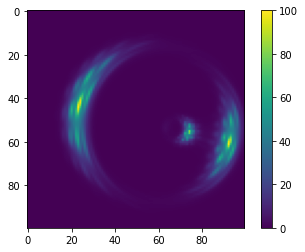

In [364]:
mu0 = simulator()
mu1 = simulator()
obs0 = noise(mu0)
obs1 = noise(mu1)
plt.imshow(obs0['mu'])
plt.colorbar()

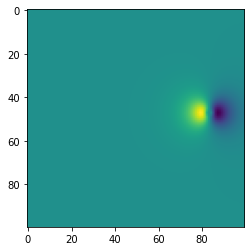

In [365]:
plt.imshow(obs1['dX'])

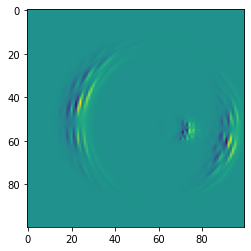

In [366]:
from scipy.ndimage import convolve

def get_directions(img):
    kernel1 = np.array([[-1, 1]])
    kernel2 = np.array([[-1], [1]])
    conv1_img = convolve(img, kernel1)
    conv2_img = convolve(img, kernel2)
    return conv1_img, conv2_img
    
img = obs0['mu']
imgX, imgY = get_directions(img)
plt.imshow(imgX)

In [367]:
from sklearn.neighbors import BallTree

sx = obs0['DX'] + obs0["X"]
sy = obs0['DY'] + obs0["Y"]
pos_src = np.array([sx.flatten(), sy.flatten()]).T
X = obs0['X']
Y = obs0['Y']
pos_img = np.array([X.flatten(), Y.flatten()]).T

nbrs_src = BallTree(pos_src)
nbrs_img = BallTree(pos_img)
idx_src = nbrs_src.query(pos_src, k=100, return_distance = False)[:,1:]
idx_img = nbrs_img.query(pos_img, k=100, return_distance = False)[:,:]

idx_clean = []
for i in range(len(idx_src)):
    kmax = 4
    idx = [j for j in idx_src[i] if j not in idx_img[i]][:kmax]
    idx += [i]*(kmax-len(idx))
    idx_clean.append(idx)
idx_clean = np.array(idx_clean)

In [368]:
mu0 = simulator(nsub = 0, source_kwargs = dict(freq = 10., w = 0.3))
obs0 = noise(mu0)
mu1 = simulator(nsub = 2, subpos = [[-1.3, -0.4], [1.3, 0.1]], source_kwargs = dict(freq = 10.1, w = 0.3))
obs1 = noise(mu1, sigma = 1.0)

In [369]:
mu0 = obs0['mu']*1.
mu1 = obs1['mu']*1.
mu0_rep = mu0.flatten()[idx_clean].mean(axis=1).reshape(100, 100)
mu1_rep = mu1.flatten()[idx_clean].mean(axis=1).reshape(100, 100)

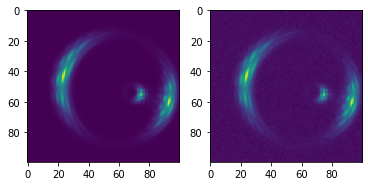

In [370]:
plt.subplot(121)
plt.imshow(mu0)
plt.subplot(122)
plt.imshow(mu1)

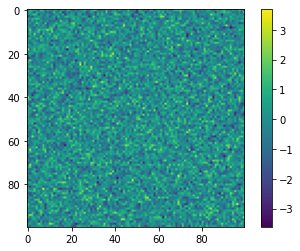

In [371]:
plt.imshow(mu0-mu1)
plt.colorbar()

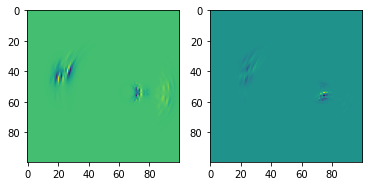

In [372]:
plt.subplot(121)
plt.imshow(obs1['dX']*imgX)
plt.subplot(122)
plt.imshow(obs1['dY']*imgY)

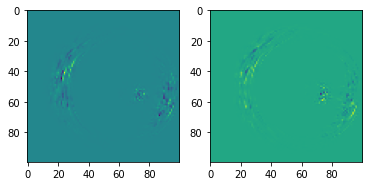

In [373]:
shift = (mu1_rep-mu0_rep)
plt.subplot(121)
plt.imshow(-shift*imgX)
plt.subplot(122)
plt.imshow(-shift*imgY)

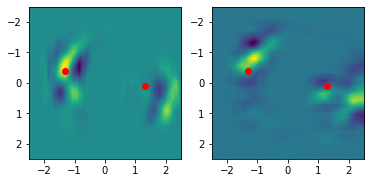

In [374]:
#fX = obs1['dX']*imgX
#fY = obs1['dY']*imgY
fX = shift*imgX
fY = shift*imgY
subpos = np.array(obs1['subpos'])
fXk = convolve(fX, -kx)
fYk = convolve(fY, -ky)
plt.subplot(121)
plt.imshow(fXk, extent = [-2.5, 2.5, 2.5, -2.5])
plt.scatter(subpos[:,0], subpos[:,1], color='r')
plt.subplot(122)
plt.imshow(fYk, extent = [-2.5, 2.5, 2.5, -2.5])
plt.scatter(subpos[:,0], subpos[:,1], color='r')

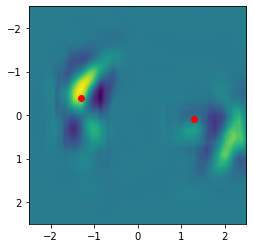

In [375]:
plt.imshow(fYk + fXk, extent = [-2.5, 2.5, 2.5, -2.5])
plt.scatter(subpos[:,0], subpos[:,1], color='r')